# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [ ]:
import pandas as pd
import numpy as np
import math
import json
import datetime
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV
warnings.filterwarnings("ignore")
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head(10)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [5]:
portfolio.offer_type.unique()


array(['bogo', 'informational', 'discount'], dtype=object)

In [6]:
portfolio.difficulty.unique()

array([10,  0,  5, 20,  7])

In [7]:
#Exploring and cleaning portfolio data
'''
Extracting channel names and offer type 

Takes portfolio data as input and slices channel dataframe and creates a dataframe with binary values 

Creates new dataframe for every offer type bogo , discount and informational

'''
def clean_port(portfolio):
#applying lambda function 
    portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
# Store all the offers as a separate column 
    offer_type = pd.get_dummies(portfolio['offer_type'])
    
    # drop the channels and offer_type column
    portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    portfolio = pd.concat([portfolio, offer_type], axis=1, sort=False)
    
    return portfolio


In [8]:
portfolio = clean_port(portfolio)
portfolio.head()

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


In [9]:
#cleaning_profile_data
#removing the values with age =118
profile = profile[profile.age!=118]

In [10]:
#lets check for any unusual age
profile.gender.unique()
profile.age.unique()

array([ 55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,  78,
        42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,  54,
        39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,  27,
        73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,  83,
        43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,  25,
        37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,  93,
        91,  92,  98, 101,  97,  99])

In [11]:

'''
Cleaning profile dataframe .. takes profile data as input 
calculates days since the person became a member by calculating the difference between time of registration and todays date

Replaces gender values with 0 ,1 , -1 

'''
def clean_profile(profile):

    profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')
    profile['days'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['days'] = profile['days'].dt.days
    # drop all missing values
    recode = {'M': 1, 'F': 0, 'O' :-1}
    profile.replace({'gender': recode},inplace=True)
    profile.dropna(inplace=True)
    return profile                                             

In [12]:
cleaned_profile = clean_profile(profile)
#cleaned_profile.head()
profile.head()

,age,became_member_on,gender,id,income,days
1,55,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,1138
3,75,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1205
5,68,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,853
8,65,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,929
12,58,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1019


In [13]:
profile.isna().sum()
print('profile size  : {}'.format(profile.shape))


profile size  : (14825, 6)


In [14]:
#removing null values of gender and income
profile = profile.dropna(subset = ['gender'])

In [15]:
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
days                0
dtype: int64

In [16]:

#checking and cleaning transcript data
transcript.event.unique()
  

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [17]:
#creating a dataframe for every type of offer m

'''
SLicing columns to create new columns with _event stored as a sparate binary column
Takes transcript data as input and returns a new column with all type with event stored as a binary dataframe



'''

def clean_trans(transcript):
    trans = transcript[transcript.event == 'transaction']
    received = transcript[transcript.event == 'offer received']
    viewed = transcript[transcript.event == 'offer viewed']
    completed = transcript[transcript.event == 'offer completed']
    trans['amount'] = trans.value.apply(lambda x:list(x.values())[0])
    received['offer_id'] = received.value.apply(lambda x:list(x.values())[0])
    viewed['offer_id'] = viewed.value.apply(lambda x:list(x.values())[0])
    completed['offer_id'] = completed.value.apply(lambda x:list(x.values())[0])
    completed['reward'] = completed.value.apply(lambda x:list(x.values())[1])
    # concat the new dataframes into one dataset transcript
    transcript = pd.concat([trans,received,viewed,completed])
    # select and drop necessary columns 
    transcript = transcript[['event' , 'person' , 'offer_id' ,'time', 'amount' , 'reward' , 'value']]
    transcript.drop(columns='value' , inplace=True)
    
    return transcript


In [18]:
clean_transcript = clean_trans(transcript)
transcript = pd.get_dummies(clean_transcript , columns=['event'] , prefix='' ,prefix_sep='')


In [19]:
#basic data exploration of users 

profile[profile['income'].notnull()].describe()

,age,gender,income,days
count,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,0.557976,65404.991568,1284.478988
std,17.383705,0.524650,21598.299410,419.205158
min,18.000000,-1.000000,30000.000000,762.000000
25%,42.000000,0.000000,49000.000000,970.000000
50%,55.000000,1.000000,64000.000000,1120.000000
75%,66.000000,1.000000,80000.000000,1559.000000
max,101.000000,1.000000,120000.000000,2585.000000


In [20]:
profile.gender.value_counts()


 1    8484
 0    6129
-1     212
Name: gender, dtype: int64

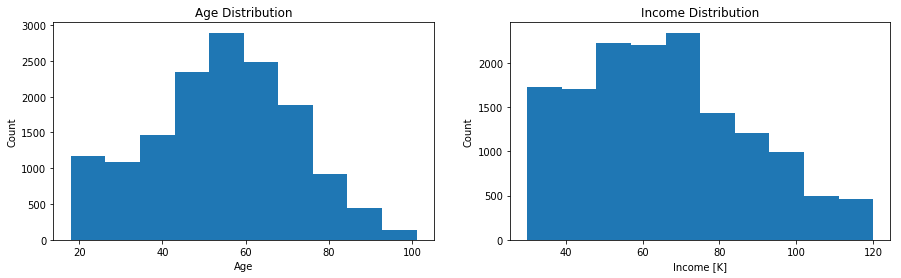

In [21]:
#comparison of ge and income of customers

fig, ax = plt.subplots(figsize=(15, 4), nrows=1, ncols=2)

# plot a age distribution in data
plt.sca(ax[0])
plt.hist(profile['age'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')

# plot a income distribution in data
plt.sca(ax[1])
plt.hist(profile['income'] * 1E-3 )
plt.xlabel('Income [K]')
plt.ylabel('Count')
plt.title('Income Distribution');




#The median age of customers is 60 whereas median income of starbucks customers is in the range of 70-80k  


In [22]:
# creating a new df by combining profile and transcript data
'''
Mergingcleaned transcript profile and portfolio dataframes to create our model


'''
new_df = pd.merge(transcript , profile ,left_on='person' , right_on='id',how='inner')
new_df.drop(columns=['id'] , inplace=True)
# Fill nans with 0
new_df.reward.fillna(0 , inplace=True)
new_df.amount.fillna(0 , inplace=True)
new_df.dropna(subset=['offer_id'] ,inplace=True)
new_df.head()

,person,offer_id,time,amount,reward,offer completed,offer received,offer viewed,transaction,age,became_member_on,gender,income,days
10,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,0.0,0.0,0,1,0,0,20,2016-07-11,0,30000.0,1507
11,02c083884c7d45b39cc68e1314fec56c,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,0.0,0.0,0,1,0,0,20,2016-07-11,0,30000.0,1507
12,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,0.0,0.0,0,0,1,0,20,2016-07-11,0,30000.0,1507
25,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,0,0.0,0.0,0,1,0,0,42,2016-01-17,1,96000.0,1683
26,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2298d6c36e964ae4a3e7e9706d1fb8c2,336,0.0,0.0,0,1,0,0,42,2016-01-17,1,96000.0,1683


In [23]:
#combining new_df with portfolio data

comb_data =new_df.merge(portfolio)
comb_data.head()

,person,offer_id,time,amount,reward,offer completed,offer received,offer viewed,transaction,age,...,difficulty,duration,id,web,email,mobile,social,bogo,discount,informational
0,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,0.0,0.0,0,1,0,0,20,...,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
1,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,0.0,0.0,0,1,0,0,20,...,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
2,02c083884c7d45b39cc68e1314fec56c,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,0.0,0.0,0,1,0,0,20,...,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,02c083884c7d45b39cc68e1314fec56c,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,0.0,0.0,0,1,0,0,20,...,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
4,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,0.0,0.0,0,0,1,0,20,...,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1


In [24]:

#Checking the number of bogo offers completed and storing the in a new column new_bogo 
comb_data.loc[(comb_data['offer completed'] == 0) & (comb_data['bogo'] == 1), 'new_bogo'] = 0
comb_data.loc[(comb_data['offer completed']==1) & (comb_data['bogo'] == 1), 'new_bogo'] = 1

# Checking the number of discount offers completed and storing them in a new column as new_discount
comb_data.loc[(comb_data['offer completed'] == 0) & (comb_data['discount'] == 1), 'new_discount'] = 0
comb_data.loc[(comb_data['offer completed']==1) & (comb_data['discount'] == 1) , 'new_discount'] = 1


In [25]:

comb_data['new_bogo'] = comb_data['new_bogo'].replace(np.nan, 0)
 

In [26]:
comb_data['new_discount'] = comb_data['new_discount'].replace(np.nan, 0)

In [27]:
#comb_data.new_discount.value_counts()

In [28]:
'''
creating a train test split where target variable is new_bogo and new_discount


'''


new_data = comb_data[['age', 'income','new_bogo','new_discount','duration','days', 'time','gender','web','mobile','social']]
X = new_data.drop(columns=['new_discount' ,'new_bogo'])
y_bogo = new_data.new_bogo
y_discount= new_data.new_discount
new_data.head()
                  

,age,income,new_bogo,new_discount,duration,days,time,gender,web,mobile,social
0,20,30000.0,0.0,0.0,4,1507,0,0,1,1,0
1,20,30000.0,0.0,0.0,3,1507,0,0,0,1,1
2,20,30000.0,0.0,0.0,4,1507,408,0,1,1,0
3,20,30000.0,0.0,0.0,3,1507,408,0,0,1,1
4,20,30000.0,0.0,0.0,4,1507,0,0,1,1,0


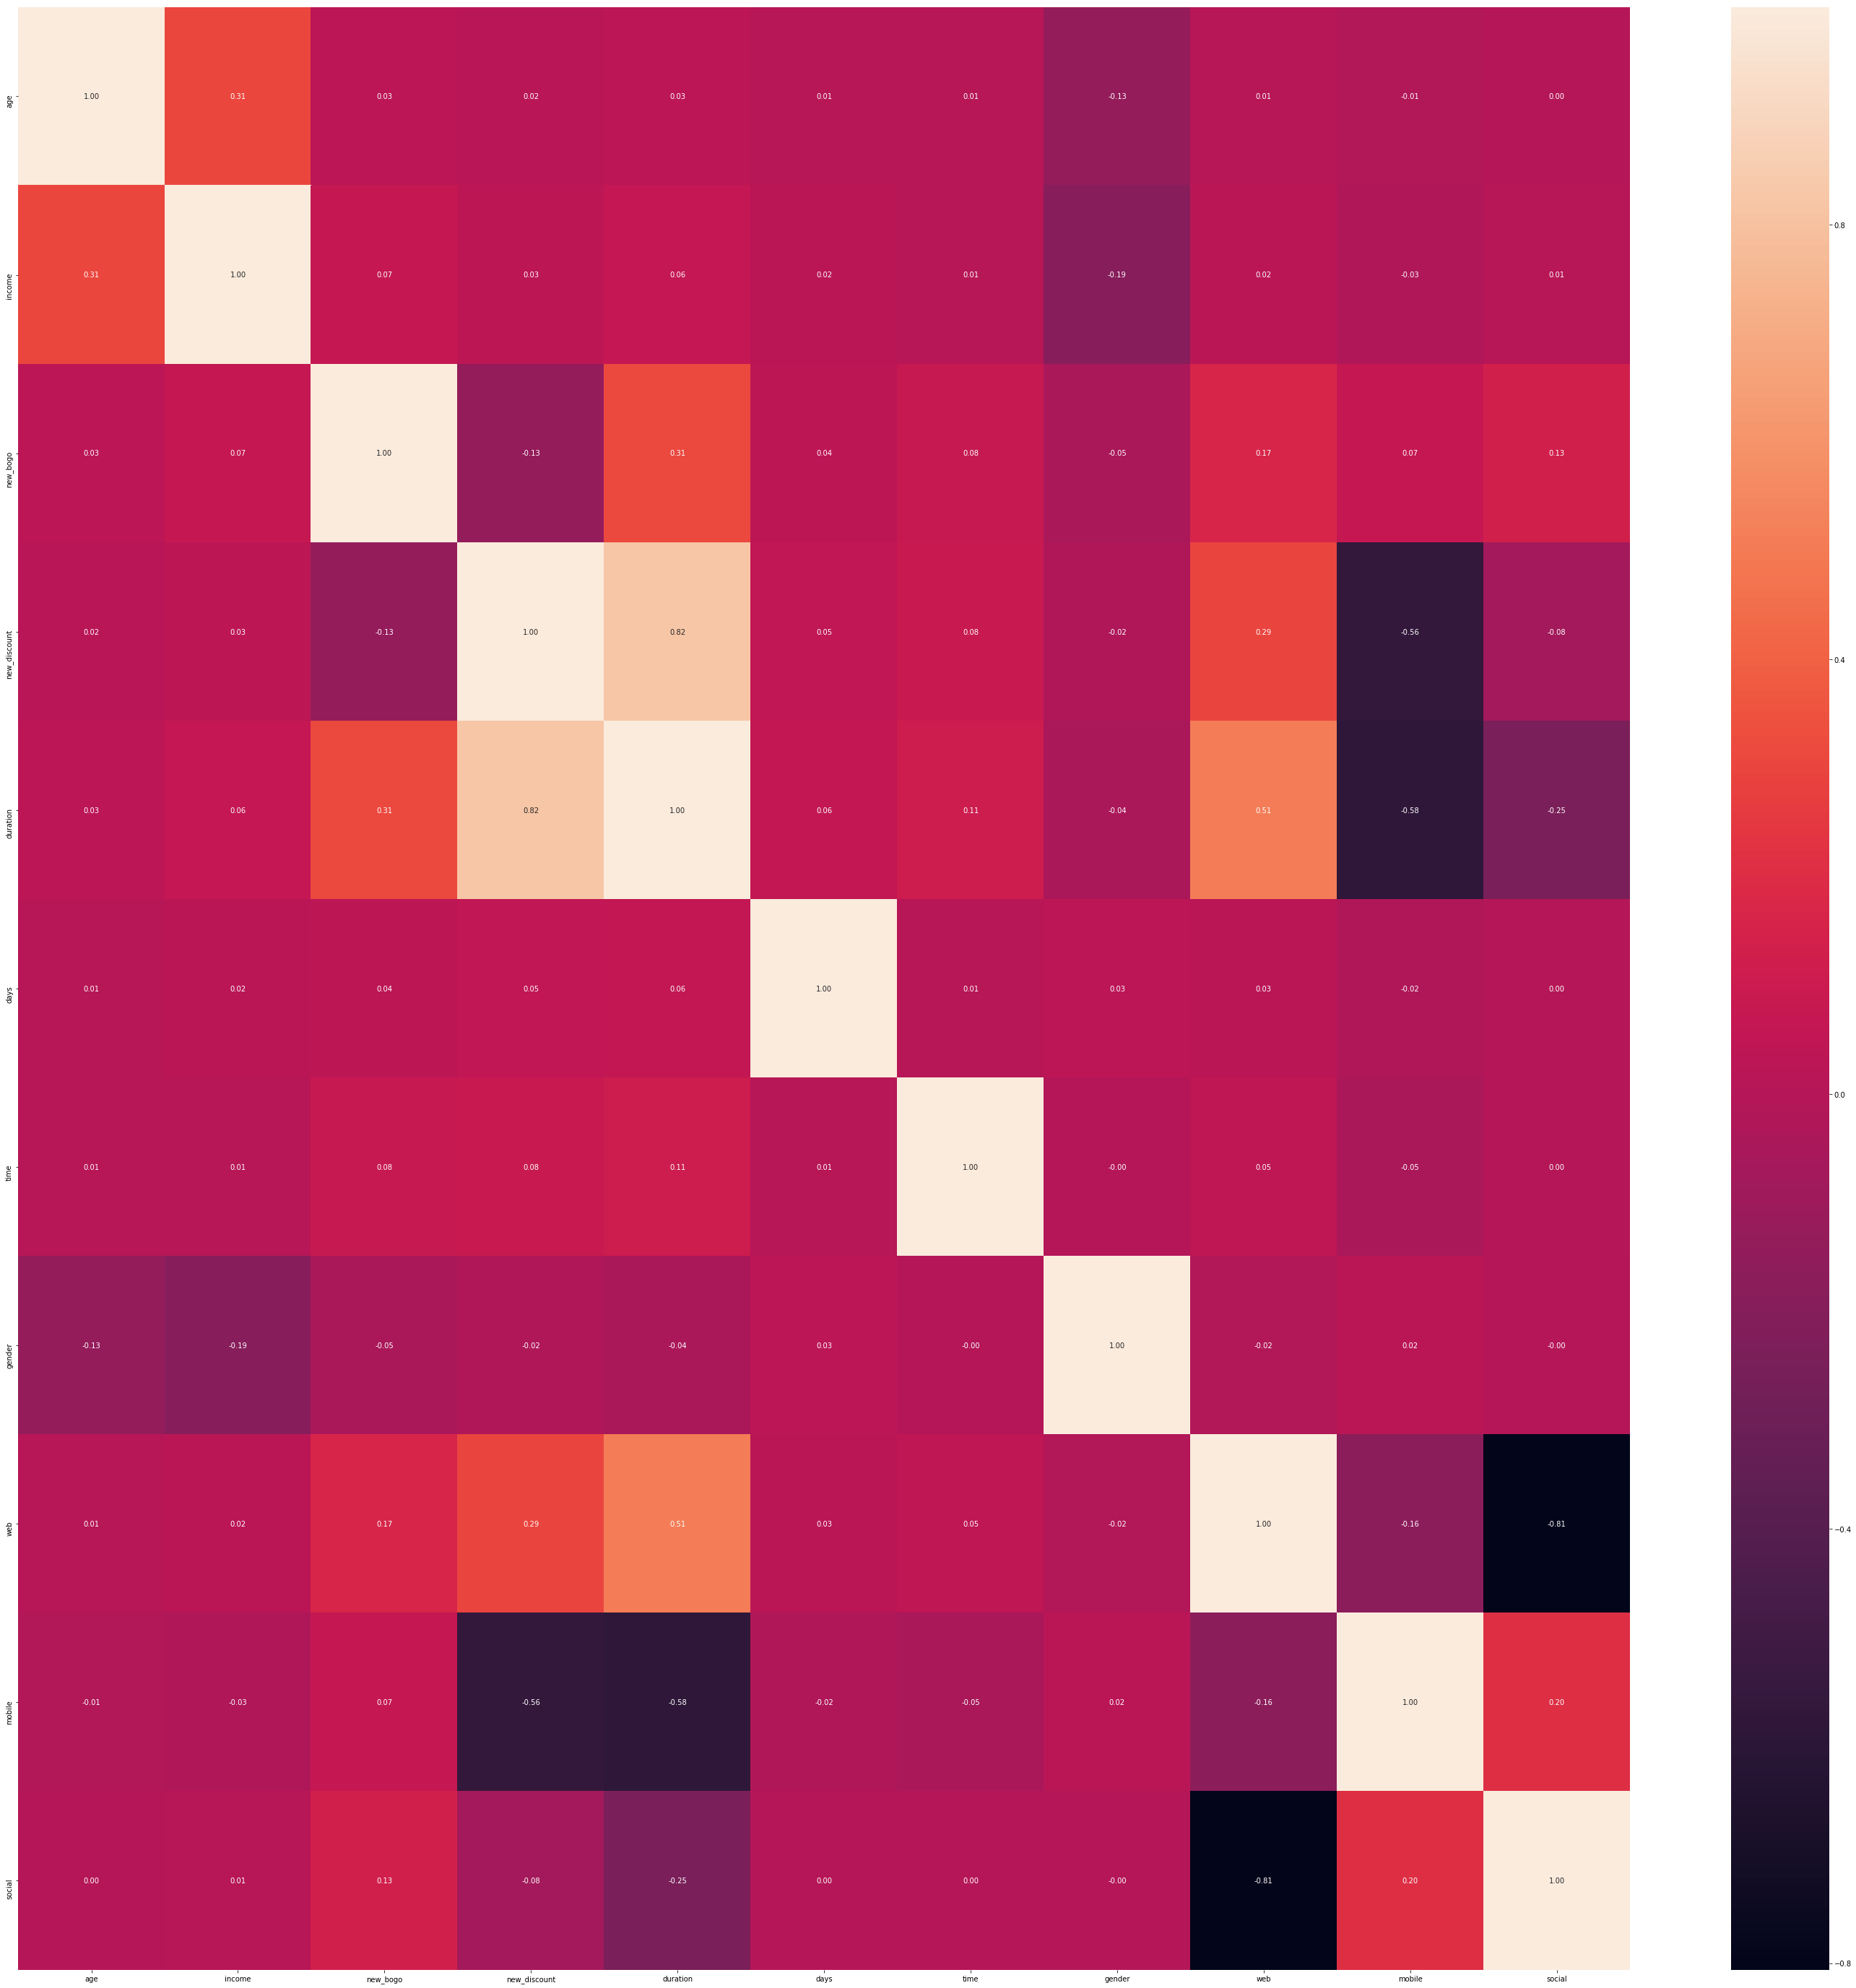

In [29]:
import matplotlib as plt
fig, ax = plt.pyplot.subplots(figsize=(50,50))
sns.heatmap(new_data.corr(), annot=True, fmt='.2f');
#from the below heatmap we can see that duration is highly correlated with bogo and discount offers that is more the duration
#more likely will the customer resppnd to the offer
# another thing we notice is that customers with higher income will respond to bogo offer than discount offer

In [30]:
X_train, X_test, y_bogo_train, y_bogo_test = train_test_split(X, y_bogo, random_state=42)
X_train, X_test, y_discount_train, y_discount_test = train_test_split(X, y_discount, random_state=42)

In [31]:
LR_bogo = LogisticRegression()
LR_discount = LogisticRegression()
LR_bogo.fit(X_train, y_bogo_train)
LR_discount.fit(X_train, y_discount_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
print(f'Bogo offer Accuracy of  LogisticRegression on training set: {round(LR_bogo.score(X_train,y_bogo_train)*100,2)}%.')

print(f'Bogo offer Accuracy of  LogisticRegression on test set: {round(LR_bogo.score(X_test,y_bogo_test)*100,2)}%.')
print(f'Discount offer Accuracy of  LogisticRegression on training set: {round(LR_discount.score(X_train,y_discount_train)*100,2)}%.')
print(f'Discount offer Accuracy of  LogisticRegression on test set: {round(LR_discount.score(X_test,y_discount_test)*100,2)}%.')

Bogo offer Accuracy of  LogisticRegression on training set: 87.72%.
Bogo offer Accuracy of  LogisticRegression on test set: 87.83%.
Discount offer Accuracy of  LogisticRegression on training set: 94.61%.
Discount offer Accuracy of  LogisticRegression on test set: 94.58%.


In [33]:


RF_bogo = RandomForestRegressor(n_estimators=10,min_samples_leaf=20)
RF_discount = RandomForestRegressor(n_estimators=10,min_samples_leaf=20)
RF_bogo.fit(X_train, y_bogo_train)
RF_discount.fit(X_train, y_discount_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [34]:
print(f'Bogo offer Accuracy of   RandomForestRegressor on training set: {round(RF_bogo.score(X_train,y_bogo_train)*100,2)}%.')
print(f'Bogo offer Accuracy of   RandomForestRegressor on test set: {round(RF_bogo.score(X_test,y_bogo_test)*100,2)}%.')
print(f'Discount offer Accuracy of   RandomForestRegressor on training set: {round(RF_discount.score(X_train,y_discount_train)*100,2)}%.')
print(f'Discount offer Accuracy of   RandomForestRegressor on test set: {round(RF_discount.score(X_test,y_discount_test)*100,2)}%.')

Bogo offer Accuracy of   RandomForestRegressor on training set: 86.93%.
Bogo offer Accuracy of   RandomForestRegressor on test set: 83.92%.
Discount offer Accuracy of   RandomForestRegressor on training set: 86.0%.
Discount offer Accuracy of   RandomForestRegressor on test set: 82.96%.


In [35]:

DT_bogo = DecisionTreeClassifier()
DT_discount = DecisionTreeClassifier()
DT_bogo.fit(X_train, y_bogo_train)
DT_discount.fit(X_train, y_discount_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [36]:
print(f'Bogo offer Accuracy of  DecisionTreeClassifier on training set: {round(DT_bogo.score(X_train,y_bogo_train)*100,2)}%.')
print(f'Bogo offer Accuracy of  DecisionTreeClassifier on test set: {round(DT_bogo.score(X_test,y_bogo_test)*100,2)}%.')
print(f'Discount offer Accuracy of  DecisionTreeClassifier on training set: {round(DT_discount.score(X_train,y_discount_train)*100,2)}%.')
print(f'Discount offer Accuracy of  DecisionTreeClassifier on test set: {round(DT_discount.score(X_test,y_discount_test)*100,2)}%.')

Bogo offer Accuracy of  DecisionTreeClassifier on training set: 99.85%.
Bogo offer Accuracy of  DecisionTreeClassifier on test set: 96.7%.
Discount offer Accuracy of  DecisionTreeClassifier on training set: 99.85%.
Discount offer Accuracy of  DecisionTreeClassifier on test set: 96.71%.


In [37]:

KNN_bogo = KNeighborsClassifier()
KNN_discount = KNeighborsClassifier()
KNN_bogo.fit(X_train, y_bogo_train)
KNN_discount.fit(X_train, y_discount_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [38]:
print(f'Bogo offer Accuracy of  KNeighborsClassifier on training set: {round(KNN_bogo.score(X_train,y_bogo_train)*100,2)}%.')
print(f'Bogo offer Accuracy of  KNeighborsClassifier on test set: {round(KNN_bogo.score(X_test,y_bogo_test)*100,2)}%.')
print(f'Discount offer Accuracy of  KNeighborsClassifier on training set: {round(KNN_discount.score(X_train,y_discount_train)*100,2)}%.')
print(f'Discount offer Accuracy of  KNeighborsClassifier on test set: {round(KNN_discount.score(X_test,y_discount_test)*100,2)}%.')

Bogo offer Accuracy of  KNeighborsClassifier on training set: 89.32%.
Bogo offer Accuracy of  KNeighborsClassifier on test set: 86.96%.
Discount offer Accuracy of  KNeighborsClassifier on training set: 90.38%.
Discount offer Accuracy of  KNeighborsClassifier on test set: 88.08%.


In [39]:

models_bogo = [LR_bogo, KNN_bogo, RF_bogo, DT_bogo ]
models_discount = [LR_discount, KNN_discount, RF_discount, DT_discount]
model_names = [type(n).__name__ for n in models_bogo]
bogo_tr_accuracy = [x1.score(X_train, y_bogo_train)*100 for x1 in models_bogo]
discount_tr_accuracy = [x2.score(X_train, y_discount_train)*100 for x2 in models_discount]
bogo_test_accuracy = [y1.score(X_test,y_bogo_test)*100 for y1 in models_bogo]
discount_test_accuracy = [y2.score(X_test,y_discount_test)*100 for y2 in models_discount]

In [40]:
'''
            
 Decision tree classifier provides the best accuracy on training and test data with an accuracy of almost
            99%
                    
'''


results = [bogo_tr_accuracy, discount_tr_accuracy,bogo_test_accuracy,discount_test_accuracy]
results_df = pd.DataFrame(results, columns = model_names,index=['Bogo Training Accuracy', 'Bogo Test Accuracy','Discount Training Accuracy', 'Discount Test Accuracy']) 
results_df

          
           

,LogisticRegression,KNeighborsClassifier,RandomForestRegressor,DecisionTreeClassifier
Bogo Training Accuracy,87.724485,89.323259,86.928069,99.852387
Bogo Test Accuracy,94.605344,90.381954,85.998153,99.852387
Discount Training Accuracy,87.828018,86.960750,83.918304,96.699124
Discount Test Accuracy,94.583514,88.077686,82.955004,96.714892
